This notebook exists to mainly find out the best model used for prediction.

In [29]:
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import seaborn as sns
sns.set(font_scale=1.2)
import matplotlib.pyplot as plt

### Gradient Boosting Regressor

In [2]:
gb_hyperparameters = {
    'n_estimators': [100,50],
    'max_depth': [10,5],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'loss': ['squared_error'],
    'ccp_alpha': [0.0,0.1],
    'min_weight_fraction_leaf': [0.0,0.1],
    'validation_fraction': [0.2,0.25],
}

score = {
    'score':['train','test','R2','RMSE','MAE','MAPE']
}

A. Sale Data

In [3]:
df_train = pd.read_csv('../data/iProperty_sale_to_be_trained.csv')

df_train.drop(['name','psf','area'], axis=1, inplace=True)

for col in ['price']:
    q_low = df_train[col].quantile(0.01)
    q_hi  = df_train[col].quantile(0.99)
    df_train = df_train[(df_train[col] < q_hi) & (df_train[col] > q_low)]
    
one_hot = pd.get_dummies(df_train[['district','state','type','details']])
df_train = df_train.join(one_hot).drop(['district','state','type','details'], axis=1)

x = df_train.drop(['price'],axis=1)
y = df_train['price']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [4]:
gb = GradientBoostingRegressor()

gb.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [5]:
model = GridSearchCV(estimator=gb, param_grid=gb_hyperparameters, cv=5, n_jobs=-1, verbose=4)
model.fit(x_train, y_train)
pd.DataFrame.from_dict(model.cv_results_).sort_values(['mean_test_score','std_test_score'],ascending=False).T

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,0,1,16,17,25,9,24,8,18,2,...,21,4,22,7,6,23,31,14,30,15
mean_fit_time,25.528013,25.019989,28.199648,26.077603,14.767718,13.574942,13.662036,14.16536,13.144272,12.484694,...,10.774367,10.973449,5.484637,5.812857,5.904327,5.481648,4.799541,5.096935,5.468782,5.347183
std_fit_time,0.983774,0.986345,2.027129,1.020442,0.989159,0.909472,1.050853,0.858533,0.849623,0.310498,...,0.443965,0.891646,0.442702,0.655245,0.536808,0.27581,0.222494,0.203455,0.381781,0.316216
mean_score_time,0.048004,0.040175,0.056417,0.052365,0.031896,0.030994,0.036173,0.032008,0.042167,0.034296,...,0.038071,0.033423,0.025965,0.025528,0.03311,0.035102,0.01805,0.02452,0.028557,0.029165
std_score_time,0.01023,0.00817,0.012897,0.006205,0.000719,0.003938,0.006106,0.009375,0.013176,0.004459,...,0.006317,0.002763,0.007674,0.009565,0.009831,0.003969,0.004825,0.008071,0.006448,0.006798
param_ccp_alpha,0.0,0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.1,0.0,...,0.1,0.0,0.1,0.0,0.0,0.1,0.1,0.0,0.1,0.0
param_loss,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,...,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error
param_max_depth,10,10,10,10,5,5,5,5,10,10,...,10,10,10,10,10,10,5,5,5,5
param_min_samples_leaf,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
param_min_samples_split,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
param_min_weight_fraction_leaf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [6]:
gb_best_params = model.best_params_

gb_best_params

{'ccp_alpha': 0.0,
 'loss': 'squared_error',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'validation_fraction': 0.2}

In [7]:
key = 'SALE'

gb = GradientBoostingRegressor()
gb.set_params(**gb_best_params)
gb.fit(x_train,y_train)
y_pred = gb.predict(x_test)

score[key] = []
score[key].append(gb.score(x_train,y_train))
score[key].append(gb.score(x_test,y_test))
score[key].append(r2_score(y_test,y_pred))
score[key].append(mean_squared_error(y_test,y_pred, squared=False))
score[key].append(mean_absolute_error(y_test,y_pred))
score[key].append(mean_absolute_percentage_error(y_test,y_pred))

In [8]:
score

{'score': ['train', 'test', 'R2', 'RMSE', 'MAE', 'MAPE'],
 'SALE': [0.9193965566250999,
  0.785240086338416,
  0.785240086338416,
  473110.0373973638,
  257184.9235693283,
  0.26293963159570116]}

B. Rent Data

In [9]:
df_train = pd.read_csv('../data/iProperty_rent_to_be_trained.csv')

df_train.drop(['name','psf','area'], axis=1, inplace=True)

for col in ['price']:
    q_low = df_train[col].quantile(0.01)
    q_hi  = df_train[col].quantile(0.99)
    df_train = df_train[(df_train[col] < q_hi) & (df_train[col] > q_low)]
    
one_hot = pd.get_dummies(df_train[['district','state','type','details']])
df_train = df_train.join(one_hot).drop(['district','state','type','details'], axis=1)

In [10]:
gb = GradientBoostingRegressor()

gb.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [11]:
model = GridSearchCV(estimator=gb, param_grid=gb_hyperparameters, cv=5, n_jobs=-1, verbose=4)
model.fit(x_train, y_train)
pd.DataFrame.from_dict(model.cv_results_).sort_values(['mean_test_score','std_test_score'],ascending=False).T

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,0,16,1,17,8,9,25,24,2,18,...,21,20,7,6,22,23,30,31,14,15
mean_fit_time,24.64163,26.371591,24.80509,25.515549,13.236982,13.180842,14.999228,13.846317,12.449634,13.07021,...,10.486832,10.723005,5.267373,5.051268,5.762976,5.290581,5.39034,4.794727,5.322885,5.41567
std_fit_time,0.372101,1.801728,0.143489,1.447609,0.291984,0.382457,1.198674,1.334111,0.434993,0.885977,...,0.713234,0.190034,0.22615,0.049179,0.500539,0.189357,0.428521,0.688844,0.440159,0.185648
mean_score_time,0.044477,0.047872,0.053438,0.051656,0.029545,0.03214,0.035462,0.032464,0.041131,0.043119,...,0.032424,0.035923,0.020619,0.026922,0.032893,0.019656,0.029234,0.02083,0.031793,0.032327
std_score_time,0.005627,0.0131,0.004048,0.006557,0.004747,0.000801,0.006041,0.000559,0.012996,0.013477,...,0.009904,0.007142,0.005929,0.008344,0.0115,0.006702,0.011762,0.006643,0.017174,0.000651
param_ccp_alpha,0.0,0.1,0.0,0.1,0.0,0.0,0.1,0.1,0.0,0.1,...,0.1,0.1,0.0,0.0,0.1,0.1,0.1,0.1,0.0,0.0
param_loss,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,...,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error
param_max_depth,10,10,10,10,5,5,5,5,10,10,...,10,10,10,10,10,10,5,5,5,5
param_min_samples_leaf,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
param_min_samples_split,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
param_min_weight_fraction_leaf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [12]:
gb_best_params = model.best_params_

gb_best_params

{'ccp_alpha': 0.0,
 'loss': 'squared_error',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'validation_fraction': 0.2}

In [13]:
key = 'RENT'

gb = GradientBoostingRegressor()
gb.set_params(**gb_best_params)
gb.fit(x_train,y_train)
y_pred = gb.predict(x_test)

score[key] = []
score[key].append(gb.score(x_train,y_train))
score[key].append(gb.score(x_test,y_test))
score[key].append(r2_score(y_test,y_pred))
score[key].append(mean_squared_error(y_test,y_pred, squared=False))
score[key].append(mean_absolute_error(y_test,y_pred))
score[key].append(mean_absolute_percentage_error(y_test,y_pred))

Display

In [15]:
score_df = pd.DataFrame(score).T
score_df.columns = score_df.iloc[0]
score_df = score_df[1:]
score_df = score_df.reset_index()
score_df.rename(columns={'index':'data'}, inplace=True)
score_df

score,data,train,test,R2,RMSE,MAE,MAPE
0,SALE,0.919397,0.78524,0.78524,473110.037397,257184.923569,0.26294
1,RENT,0.919397,0.78606,0.78606,472206.278174,257095.600781,0.263026


(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

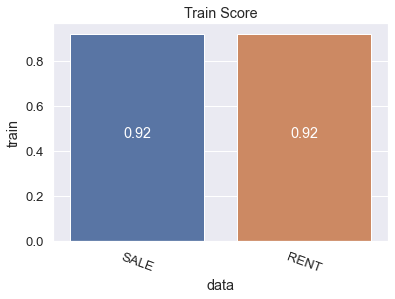

In [30]:
p = sns.barplot(data=score_df, x='data', y='train')
p.set_title('Train Score')
for i in range(len(score_df)):
    p.text(i,score_df.train[i]/2,str(round(score_df.train[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

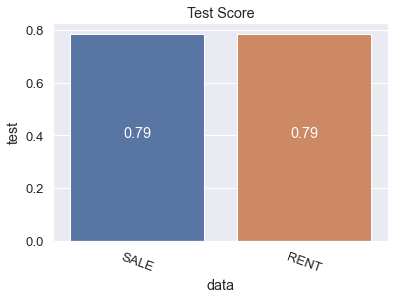

In [31]:
p = sns.barplot(data=score_df, x='data', y='test')
p.set_title('Test Score')
for i in range(len(score_df)):
    p.text(i,score_df.test[i]/2,str(round(score_df.test[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

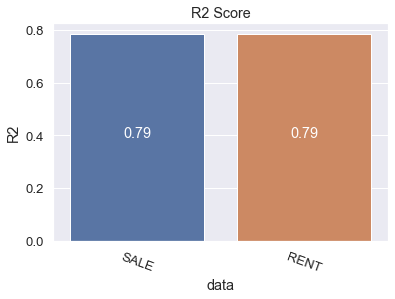

In [32]:
p = sns.barplot(data=score_df, x='data', y='R2')
p.set_title('R2 Score')
for i in range(len(score_df)):
    p.text(i,score_df.R2[i]/2,str(round(score_df.R2[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

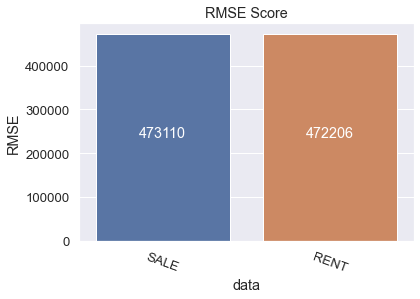

In [33]:
p = sns.barplot(data=score_df, x='data', y='RMSE')
p.set_title('RMSE Score')
for i in range(len(score_df)):
    p.text(i,score_df.RMSE[i]/2,str(round(score_df.RMSE[i])),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

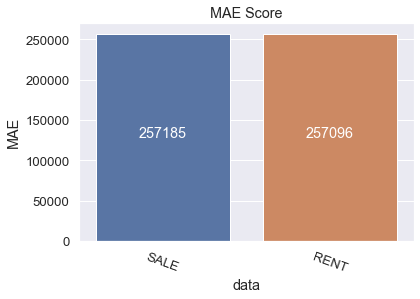

In [34]:
p = sns.barplot(data=score_df, x='data', y='MAE')
p.set_title('MAE Score')
for i in range(len(score_df)):
    p.text(i,score_df.MAE[i]/2,str(round(score_df.MAE[i])),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

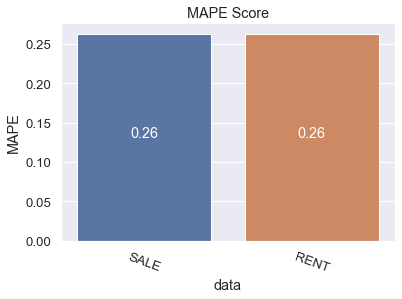

In [35]:
p = sns.barplot(data=score_df, x='data', y='MAPE')
p.set_title('MAPE Score')
for i in range(len(score_df)):
    p.text(i,score_df.MAPE[i]/2,str(round(score_df.MAPE[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)